# Hallway Experiments in Curriculum Learning

-------------------------------


Salkey, Jayson

28/06/2018

-----------------------------------


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [1214]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from collections import namedtuple

### Set options

In [1215]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=1)

### Helper functions

### A grid world

In [1216]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, discount=0.98, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
      
    
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
  
  def resetState(self):
    self._state = self._start_state
    
  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(3, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      reward = float((new_y + new_x)) / float(np.sum(self._layout.shape))
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### A hallway world

In [1217]:
class Hallway(object):

  def __init__(self, goal_loc, value=5, tabular=True, vision_size=1, discount=0.98, noisy=False):
    # -3: Key
    # -2: Door
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    
    self._wall = -1
    self._door = -2
    self._key = -3
    
    self.goal_loc_r = goal_loc[0]
    self.goal_loc_c = goal_loc[1]
    
    self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1],
        [-1,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1],
        [-1,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1],
        [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1],
        [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1],
        [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1],
        [-1,  0,  0,  0, -1, -1, -1,  0,  0, -1, -1, -1, -2, -2, -1, -1, -1],
        [-1,  0,  0,  0, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0,  0, -1, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1, -1,  0,  0,  0, -1, -1],
        [-1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      ])
    
    
    
    self._layout[self.goal_loc_r,self.goal_loc_c] = value
    self._goal = value
    # col, row format
    self._start_state = (8, 11)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
    self._distanceToGoal = None
    
    self.distanceToGoal()
  
  def resetState(self):
    self._state = self._start_state
  
  def distanceToGoal(self):
    return np.prod(self._layout.shape)
#     if self._distanceToGoal != None:
#       return self._distanceToGoal
#     else:
#       #print self._layout.shape
#       distances = []
#       stack = []
#       visited = set()
#       stack.append((self._start_state[1], self._start_state[0], 0))
#       while len(stack) != 0:
#         #print len(stack)
#         cur_row, cur_col, dist = stack.pop()
#         if (cur_row, cur_col) in visited:
#           continue
#         visited.add((cur_row, cur_col))

#         if cur_row == self.goal_loc_r and cur_col == self.goal_loc_c:
#           distances.append(dist)

#         if cur_row+1 < self._layout.shape[0] and self._layout[cur_row+1, cur_col] != self._wall:
#           stack.append((cur_row+1, cur_col, dist+1))
#         if cur_row-1 > -1 and self._layout[cur_row-1, cur_col] != self._wall:
#           stack.append((cur_row-1, cur_col, dist+1))
#         if cur_col+1 < self._layout.shape[1] and self._layout[cur_row, cur_col+1] != self._wall:
#           stack.append((cur_row, cur_col+1, dist+1))
#         if cur_col-1 > -1 and self._layout[cur_row, cur_col-1] != self._wall:
#           stack.append((cur_row, cur_col-1, dist+1))

#       self._distanceToGoal = np.max(np.array(distances))
#       return self._distanceToGoal
    
  def handleDoor(self):
    pass
  
  @property
  def number_of_states(self):
    return self._number_of_states
    
  def plot_grid(self, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != self._wall, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    
    if title != None:
      plt.title(title)
    else:
      plt.title("The Grid")
    plt.text(8, 11, r"$\mathbf{S}$", ha='center', va='center')
    if self._goal > 0:
      goal_y, goal_x = np.where(self._layout==self._goal)
      plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    else:
      key_y, key_x = np.where(self._layout==self._key)
      plt.text(key_x, key_y, r"$\mathbf{K}$", ha='center', va='center')
    y = np.where(self._layout==self._door)[0]
    x = np.where(self._layout==self._door)[1]
    for i in range(y.shape[0]): 
      #print y[i], x[i]
      plt.text(x[i], y[i], r"$\mathbf{D}$", ha='center', va='center')
    
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)
      

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action, agent_inventory):
    item = None
    y, x = self._state
        
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == self._wall:  # a wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] == self._key: # a key
      reward = 5
      item = 'KEY'
    elif self._layout[new_y, new_x] == self._door: # a door
      reward = 5
      if 'KEY' not in agent_inventory:
        reward = -1
        # What is going on here?
        #  - Perhaps the replaybuffer?dist
        #  - Perhaps it is the plotting that is fucking up
        #  - We have states, never visited.
        # we have a hole
        new_state = (y, x)
    elif self._layout[new_y, new_x] > 0: # a goal
      reward = self._layout[new_y, new_x]

      discount = 0.
      new_state = self._start_state
    else:
      #reward = float((new_y + new_x)) / float(np.sum(self._layout.shape))
      reward = 0
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs(), item
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

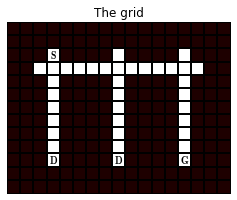

In [1218]:
grid = Grid()
grid.plot_grid()

### The Hallway(s)

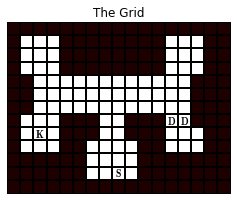

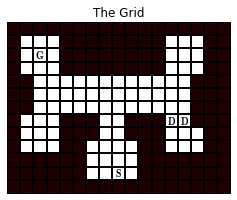

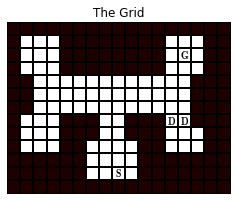

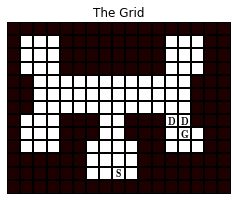

In [1219]:
tasks = []
tasks.append(Hallway(goal_loc = (8, 2), value=-3, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 2), value=1, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 13), value=1, discount=0.98))
tasks.append(Hallway(goal_loc = (8, 13), value=100, discount=0.98))
for task in tasks:
  task.plot_grid()


## Implement agents


In [1220]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, num_offline_updates=30, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._replayBuffer_A = []
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
      self._replayBuffer_B = []
    self._s = initial_state
    self._initial_state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._num_offline_updates = num_offline_updates
    self._last_action = 0
    self._inventory = set()
  
  def resetReplayBuffer(self):
    self._replayBuffer_A = []
    if self._double:
      self._replayBuffer_B = []
      
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q
    
  def resetState(self):
    self._s = self._initial_state 

  def step(self, r, g, s, item, train):
    if item != None and train == True:
      self._inventory.add(item)
      
    if self._double:
      next_action = self._behaviour_policy(self.q_values[s,:], train)
      if train == True:
        if np.random.random() <= 0.5:
          expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q2[s,:])
          self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
          #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q2[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
          self._replayBuffer_A.append([self._s,self._last_action,r,g,s,next_action])
          
          for _ in xrange(self._num_offline_updates):
            replay = self._replayBuffer_A[np.random.randint(len(self._replayBuffer_A))]
            expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
            self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])
        
        else:
          expectation = np.sum(self._target_policy(self._q2[s,:], next_action) * self._q[s,:])
          self._q2[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])   
          #self._q2[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q2[s,:], next_action))] - self._q2[self._s,self._last_action])    
          self._replayBuffer_B.append([self._s,self._last_action,r,g,s,next_action])
          
          for _ in xrange(self._num_offline_updates):
            replay = self._replayBuffer_B[np.random.randint(len(self._replayBuffer_B))]
            expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
            self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])
      
      self._s = s
      self._last_action = next_action
      return self._last_action, self._inventory
    else:
      next_action = self._behaviour_policy(self._q[s,:], train)
      if train == True:
        # This is expected sarsa, but still functions as expected.
        expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q[s,:])
        self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
        #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
        self._replayBuffer_A.append([self._s,self._last_action,r,g,s,next_action])
      
        for _ in xrange(self._num_offline_updates):
          replay = self._replayBuffer_A[np.random.randint(len(self._replayBuffer_A))]
          expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
          self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])
       
      self._s = s
      self._last_action = next_action
      return self._last_action, self._inventory
    

In [1221]:
def Q_target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

def SARSA_target_policy(q, a):
  return np.eye(len(q))[a]

def gen_behaviour_policy(q, train):
  return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])

An agent that uses **Neural-Sarsa/DQN** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
            
DQN(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

In [1222]:
class NeuralSarsa(object):

  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, num_offline_updates=30, step_size=0.01):
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._initial_state = initial_state
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    self._initial_state = initial_state
    self._times_trained = 0
    self._inventory = set()
    self._replayBuffer = []
    self._num_offline_updates = num_offline_updates
    
    self.handleTF()
  
  def resetReplayBuffer(self):
    self._replayBuffer = []
    
  def resetState(self):
    self._s = self._initial_state 
    self._s = np.reshape(self._s, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float64)
    self.disTensor = tf.placeholder(tf.float64)
    self.nqTensor = tf.placeholder(tf.float64)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float64, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    self._cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.GradientDescentOptimizer(self._step).minimize(self._cost)
    
    init = tf.global_variables_initializer()
    self._sess.run(init)

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):    
    return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def q(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q, {self.stateTensor: obs})
    return t
  
  def step(self, r, g, s, item, train):
    if item != None and train == True:
      self._inventory.add(item)
    
    # This function should return an action
    q_nxtState = np.reshape(self.q(s), (-1,))
    next_action = self._behaviour_policy(q_nxtState, train)
    target = self._target_policy(q_nxtState, next_action)
    target = np.random.choice(np.where(np.max(target) == target)[0])
    
    # Optimiser
    if train == True:
      vob = q_nxtState[target]
      self._sess.run(self._opt,{
          self.nqTensor: vob,
          self.rewTensor: r,
          self.disTensor: g,
          self.actionTensor: self._prev_action,
          self.stateTensor: self._s})
      self._replayBuffer.append([self._s, self._prev_action, r, g, vob])
      for _ in xrange(self._num_offline_updates):
        replay = self._replayBuffer[np.random.randint(len(self._replayBuffer))]
        self._sess.run(self._opt,{
            self.nqTensor: replay[4],
            self.rewTensor: replay[2],
            self.disTensor: replay[3],
            self.actionTensor: replay[1],
            self.stateTensor: replay[0]})
        
    self._s = np.reshape(s, (1,-1))
    self._prev_action = next_action
    return next_action, self._inventory

In [1223]:
class DQN(object):
  
  # Target Network is the same, as C-step is just C=1
  
  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, num_offline_updates=30, step_size=0.01):
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._initial_state = initial_state
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    self._times_trained = 0
    self._inventory = set()
    self._replayBuffer = []
    self._num_offline_updates = num_offline_updates
    
    self.handleTF()
  
  def resetReplayBuffer(self):
    self._replayBuffer = []
    
  def resetState(self):
    self._s = self._initial_state 
    self._s = np.reshape(self._s, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float64)
    self.disTensor = tf.placeholder(tf.float64)
    self.nqTensor = tf.placeholder(tf.float64)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float64, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    self._cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.GradientDescentOptimizer(self._step).minimize(self._cost)
    
    init = tf.global_variables_initializer()
    self._sess.run(init)

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):    
    return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def q(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q, {self.stateTensor: obs})
    return t
  
  def step(self, r, g, s, item, train):
    if item != None and train == True:
      self._inventory.add(item)
    
    # This function should return an action
    q_nxtState = np.reshape(self.q(s), (-1,))
    next_action = self._behaviour_policy(q_nxtState, train)
    #target = self._target_policy(q_nxtState, next_action)
    #target = np.random.choice(np.where(np.max(target) == target)[0])
    
    # Optimiser
    if train == True:
      vob = np.max(q_nxtState)
      self._sess.run(self._opt,{
          self.nqTensor: vob,
          self.rewTensor: r,
          self.disTensor: g,
          self.actionTensor: self._prev_action,
          self.stateTensor: self._s})
      self._replayBuffer.append([self._s, self._prev_action, r, g, vob])
      for _ in xrange(self._num_offline_updates):
        replay = self._replayBuffer[np.random.randint(len(self._replayBuffer))]
        self._sess.run(self._opt,{
            self.nqTensor: replay[4],
            self.rewTensor: replay[2],
            self.disTensor: replay[3],
            self.actionTensor: replay[1],
            self.stateTensor: replay[0]})

    
    self._s = np.reshape(s, (1,-1))
    self._prev_action = next_action
    return next_action, self._inventory

## Agent 0: Random

In [1224]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)
  
  def getProbs(self):
    return np.ones((self._number_of_arms))/self._number_of_arms
  
  def reset(self):
    pass


## Agent 1: REINFORCE agents
Implementation of REINFORCE policy-gradient methods

The policy should be a softmax on action preferences:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.


In [1225]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.total_reward = 0;
    self.number_rewards = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.number_rewards += 1.
      self.total_reward += reward
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
      self.updatePreferences(previous_action, reward)
#    unvisited = np.where(self.action_values[1,:] == 0.)
#     if unvisited[0].size > 0:
#       return unvisited[0][0]
#     else:
#       return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    
  def reset(self):
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.number_rewards = 0.
    self.total_reward = 0.
  
  def updatePreferences(self, previous_action, reward):
    if not self._baseline: 
      self.action_preferences[0,previous_action]+=self._lr*reward*(1-self.softmax()[previous_action])
      for i in xrange(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*reward*self.softmax()[i]
    else:
      self.action_preferences[0,previous_action]+=self._lr*(reward - self.total_reward/self.number_rewards)*(1-self.softmax()[previous_action])
      for i in xrange(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*(reward - self.total_reward/self.number_rewards)*self.softmax()[i]
    
  def softmax(self):
    q = np.sum(np.exp(self.action_preferences),axis=1)
    t = np.exp(self.action_preferences)/q
    return t.flatten()
  
  def getProbs(self):
    return self.softmax()
  
  
      

## Agent 2: EXP3

In [1226]:
class EXP3(object):

  def __init__(self, number_of_arms, gamma):
    self._number_of_arms = number_of_arms
    self.name = 'exp3 Gamma: ' + str(gamma)
    
    self.action_values = np.zeros((2,self._number_of_arms))
    
    self.gamma = gamma
    self.weights = np.ones((1,self._number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 3: EXP3.S

In [1227]:
class EXP3S(object):

  def __init__(self, number_of_arms, gamma, alpha):
    self._number_of_arms = number_of_arms
    self.name = 'exp3s Gamma: ' + str(gamma) + ', Alpha: ' + str(alpha) 
    
    self.action_values = np.zeros((2,number_of_arms))
    
    self.gamma = gamma
    self.alpha = alpha
    self.weights = np.ones((1,number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      # Should the added term be using updated weights as we move across arms, or simultaenous updates?
      #print 'test'
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms) + ((np.e*self.alpha)/(self._number_of_arms))*np.sum(self.weights)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 4: StrategicBandit with EXP3

## Agent 5: StrategicBandit with EXP4

## Agent 6: NeuralBandit

In [1228]:
# Inputs to Net are reward signal or reward_signal, and inventory
# Outputs are probabilities of arms

## Task Bandit

In [1229]:
class TaskBandit(object):
  """An adversarial multi-armed Task bandit."""
  
  
  def __init__(self, rl_agent, tasks, reward_signal):
    self._unscaled_reward_history = []
    self._rl_agent = rl_agent
    self._tasks = tasks
    self._reward_signal = reward_signal
  
  def resetEnvRLAgent(self):
    #########
      # Is this really needed?
    for ide,e in enumerate(self._tasks):
      self._tasks[ide].resetState()
    self._rl_agent.resetState()
    #########
  
  def resetReplayBuffer(self):
    self._rl_agent.resetReplayBuffer()
  
  def step(self, action_task_id):
    
    # Non-Window Method
    
    start_time = time.time()
    
    if self._reward_signal == 'PG':
      # Prediction Gain
      reward_before, reward_steps_before = run_step(self._tasks[action_task_id], self._rl_agent, False)
      run_step(self._tasks[action_task_id], self._rl_agent, True)
      reward_after, reward_steps_after = run_step(self._tasks[action_task_id], self._rl_agent, False)
      
      v = reward_steps_after - reward_steps_before
    elif self._reward_signal == 'GPG':
      # Gradient Prediction Gain
      pass
    elif self._reward_signal == 'SPG':
      # Self Prediction Gain
      reward_before, reward_steps_before = run_step(self._tasks[action_task_id], self._rl_agent, False)
      run_step(self._tasks[action_task_id], self._rl_agent, True)
      reward_after, reward_steps_after = run_step(self._tasks[action_task_id], self._rl_agent, False)
      
      v = reward_steps_after - reward_steps_before
    elif self._reward_signal == 'TPG':
      # Target Prediction Gain
      # On the Last Task
      reward_before, reward_steps_before = run_step(self._tasks[-1], self._rl_agent, False)
      run_step(self._tasks[action_task_id], self._rl_agent, True)
      reward_after, reward_steps_after = run_step(self._tasks[-1], self._rl_agent, False)
      v = reward_steps_after - reward_steps_before
    elif self._reward_signal == 'MPG':
      # Mean Prediction Gain
      # On uniformly selected task
      uniform_sampled_task_id = np.random.choice(len(self._tasks))
      reward_before, reward_steps_before = run_step(self._tasks[uniform_sampled_task_id], self._rl_agent, False)
      run_step(self._tasks[action_task_id], self._rl_agent, True)
      reward_after, reward_steps_after = run_step(self._tasks[uniform_sampled_task_id], self._rl_agent, False)
      v = reward_steps_after - reward_steps_before
    elif self._reward_signal == 'VCG':
      pass
    elif self._reward_signal == 'GVCG':
      pass
    elif self._reward_signal == 'L2G':
      pass      
    
    duration = time.time() - start_time
    
    #rhat = v/(duration)
    
    rhat = v
    
    self._unscaled_reward_history.append(rhat)
    temp_history = np.array(sorted(self._unscaled_reward_history))
    p_20 = np.percentile(temp_history, 20)
    p_80 = np.percentile(temp_history, 80)        
    #self._unscaled_reward_history.append(rhat)

    if action_task_id < 0 or action_task_id >= len(self._tasks):
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action_task_id, len(split_train_tasks)))
    
    r = None
    if rhat <= p_20:
      r = -1.
    elif rhat > p_80:
      r = 1.
    else:
      r = 2.0 * (rhat - p_20)/(p_80 - p_20) - 1.
    
    # Perhaps, plot the variance or something else, because the train==False fucks this plot up
    return r, reward_after

In [1230]:
def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, title, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  print vmin, vmax
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title(r"$v(s), \mathrm{" + title + r"}$")

def plot_greedy_policy(grid, title, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid(title)
  plt.hold('on')
  for i in range(grid._layout.shape[0]):
    for j in range(grid._layout.shape[1]):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')
      
def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

In [1231]:
def run_experiment(bandit, algs, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type, hidden_units, step_size, reward_signal):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  reward_delta_dict = {}
  action_dict = {}
  prob_dict = {}
  entropy_dict = {}
  
  for alg in algs:
    print 'Running:', alg.name
    #bandit = TaskBandit(64, 32, reward_signal, 0.01)
    #bandit = TaskBandit(rl_agent, tasks)
    reward_dict[alg.name] = []
    reward_delta_dict[alg.name] = []
    action_dict[alg.name] = []
    prob_dict[alg.name] = []
    entropy_dict[alg.name] = []
    
    accuracies = None
    rl_agent = None
    
    for qq in range(repetitions):
      alg.reset()
      rl_agent = None
      
      if agent_type == 'NEURALSARSA':
        rl_agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=hidden_units,
                    number_of_actions=4,
                    initial_state=tasks[0].get_obs(),
                    step_size=step_size)
      elif agent_type == 'DQN':
        rl_agent = DQN(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=hidden_units,
                    number_of_actions=4,
                    initial_state=tasks[0].get_obs(),
                    step_size=step_size)
      elif agent_type == 'Q':
        rl_agent = GeneralQ(number_of_states=tasks[0]._layout.size,
                number_of_actions=4,
                initial_state=tasks[0].get_obs(),
                target_policy=Q_target_policy,
                behaviour_policy=gen_behaviour_policy,
                double=True)
      elif agent_type == 'SARSA':
        rl_agent = GeneralQ(number_of_states=tasks[0]._layout.size,
                number_of_actions=4,
                initial_state=tasks[0].get_obs(),
                target_policy=SARSA_target_policy,
                behaviour_policy=gen_behaviour_policy,
                double=True)
      
      bandit = TaskBandit(rl_agent, tasks, reward_signal)
      
      reward_dict[alg.name].append([])
      reward_delta_dict[alg.name].append([])
      action_dict[alg.name].append([])
      prob_dict[alg.name].append([])
      entropy_dict[alg.name].append([])
      action = None
      reward = None
      prob = None
      entropy = None
      reward_delta = None
      
      for i in range(number_of_steps_of_selecting_tasks):
        #print i
#         if i % 100 == 0:
#           print 'Rep: {}, Step: {}'.format(qq, i)
        try:
          action = alg.step(action, reward)
          prob = alg.getProbs()
          
          entropy = -1.0 * np.sum(prob * np.log(prob))
          
        except:
            raise ValueError(
              "The step function of algorithm `{}` failed.\
              Perhaps you have a bug, such as a typo.\
              Or, perhaps your value estimates or policy has diverged.\
              (E.g., internal quantities may have become NaNs.)\
              Try adding print statements to see if you can find a bug.".format(alg.name))
        reward, reward_from_environment = bandit.step(action)
        bandit.resetReplayBuffer()
        
        reward_dict[alg.name][-1].append(reward_from_environment)
        reward_delta_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
        prob_dict[alg.name][-1].append(prob.copy())
        entropy_dict[alg.name][-1].append(entropy)
      
      if agent_type == 'NEURALSARSA':
        h, w = tasks[-1]._layout.shape
        obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
        qs = np.array([[[rl_agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        plot_action_values(qs, alg.name)
        #plot_greedy_policy(tasks[-1], alg.name, qs)
      elif agent_type == 'DQN':
        h, w = tasks[-1]._layout.shape
        obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
        qs = np.array([[[rl_agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        plot_action_values(qs, alg.name)
        #plot_greedy_policy(tasks[-1], alg.name, qs)
      elif agent_type == 'Q':
        qv = rl_agent.q_values.reshape(tasks[-1]._layout.shape + (4,))
        plot_action_values(qv, alg.name)
        #plot_greedy_policy(tasks[-1], alg.name, qv)
      elif agent_type == 'SARSA':
        qv = rl_agent.q_values.reshape(tasks[-1]._layout.shape + (4,))
        plot_action_values(qv, alg.name)
        #plot_greedy_policy(tasks[-1], alg.name, qv)
        
#       if not (accuracies is None):
#         accuracies += np.array(bandit.getSPGAccuracyList())
#       else:
#         accuracies = np.array(bandit.getSPGAccuracyList())
      
    
#     accuracies /= repetitions
      
#     plt.figure()
#     plt.plot(accuracies)
#     plt.title('Task Bandit, ' + alg.name + ', Reward Signal: ' + reward_signal)
#     plt.xlabel('Time')
#     plt.ylabel('Accuracy')
  
  return reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict

def train_task_agents(agents, number_of_arms, number_of_steps_of_selecting_tasks, tasks, reward_signal, repetitions=1, vision_size=1, tabular=False, agent_type='norm', hidden_units=100, step_size=0.01):
  bandit = None
  reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict = run_experiment(bandit, agents, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type, hidden_units, step_size, reward_signal)
  
  smoothed_rewards = {}
  smoothed_reward_deltas = {}
  smoothed_actions = {}
  smoothed_probs = {}
  smoothed_entropies = {}
  
  agent_set = set()
  
  for agent, rewards in reward_dict.items():
    agent_set.add(agent)
    smoothed_rewards[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, rewards in reward_delta_dict.items():
    agent_set.add(agent)
    smoothed_reward_deltas[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T

  
  for agent, probs in prob_dict.items():
    smoothed_probs[agent] = (np.sum(np.array([np.array(x) for x in probs]), axis=0)).T

  for agent, entropies in entropy_dict.items():
    smoothed_entropies[agent] = (np.sum(np.array([np.array(x) for x in entropies]), axis=0)).T
  
  for agent in agent_set:
    smoothed_probs[agent] /= repetitions
    
    plt.figure(figsize=(22,20))
    plt.imshow(smoothed_probs[agent], interpolation=None)
    plt.title(agent + ', Reward Signal: {}; {}'.format(reward_signal, agent_type))
    plt.xlabel('Time')
    plt.ylabel('Task')
  
  
  plt.figure(figsize=(12,12))
  plt.title('Average Reward, \t Reward Signal: {}; {}'.format(reward_signal, agent_type))
  plt.ylabel('Reward')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_rewards[agent] /= repetitions    
    plt.plot(smoothed_rewards[agent], label=agent)
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Delta Reward, \t Reward Signal: {}; {}'.format(reward_signal, agent_type))
  plt.ylabel('Delta')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_reward_deltas[agent] /= repetitions    
    plt.plot(smoothed_reward_deltas[agent], label=agent)
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Maximum Likelihood, \t Reward Signal: {}; {}'.format(reward_signal, agent_type))
  plt.ylabel('Policy Entropy')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_entropies[agent] /= repetitions  
    plt.plot(smoothed_entropies[agent], label=agent)
  plt.legend(loc='upper right')

In [1232]:
def run_step(env, agent, train): 
    
    env.resetState()
    agent.resetState()
    number_of_steps = env.distanceToGoal()
    
    try:
      action = agent.initial_action()
      agent_inventory = agent._inventory
    except AttributeError:
      action = 0
      agent_inventory = agent._inventory
      
    
    steps_completed = 0
    total_reward = 0.
    
    while steps_completed != number_of_steps:
      reward, discount, next_state, item = env.step(action, agent_inventory)
      total_reward += reward
      
      if discount == 0:
        return total_reward, total_reward/steps_completed
      
      action, agent_inventory = agent.step(reward, discount, next_state, item, train)
      steps_completed += 1
    
    mean_reward = total_reward/number_of_steps

    return total_reward, mean_reward
  
def run_episode(env, agent, number_of_episodes, train):
    # Mean Reward across all the episodes( aka all steps )
    mean_reward = 0.
    
    # Mean Duration per episode
    mean_duration = 0.
    
    # List of (Total Reward Per Epsiode)/(Duration)
    signal_per_episode = np.zeros((1, number_of_episodes))
    reward_per_episode = np.zeros((1, number_of_episodes))
    duration_per_episode = np.zeros((1, number_of_episodes))
    
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    
    episodes_completed = 0
    total_reward_per_episode = 0.
    
    start_time = time.time()
    
    i = 0.
    while episodes_completed != number_of_episodes:
      reward, discount, next_state = env.step(action)
      total_reward_per_episode += reward
      
      if discount == 0:
        duration = time.time() - start_time
        signal_per_episode[0,episodes_completed] = (total_reward_per_episode/duration)
        reward_per_episode[0,episodes_completed] = (total_reward_per_episode)
        duration_per_episode[0,episodes_completed] = (duration)
        
        episodes_completed += 1
        mean_duration += (duration - mean_duration)/(episodes_completed)
        
        start_time = time.time()
        total_reward_per_episode = 0.
        
      action = agent.step(reward, discount, next_state, train)
      mean_reward += (reward - mean_reward)/(i + 1.)
      i += 1.
    
    mean_signal = np.mean(signal_per_episode)
    total_reward = np.sum(reward_per_episode)
    total_duration = np.sum(duration_per_episode)

    return total_reward, total_duration

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

In [1233]:
number_of_steps_of_selecting_tasks = 250
reps = 1
reward_signal='TPG'
#

Running: random
-3.32933894475 0.0
Running: exp3 Gamma: 0.2
-2.708842732 0.0
Running: exp3 Gamma: 0.7
-2.83644682835 0.0


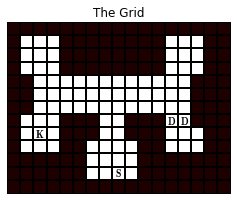

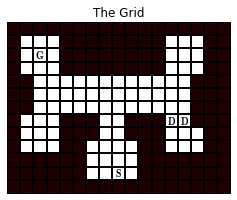

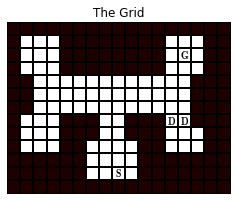

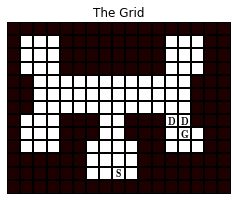

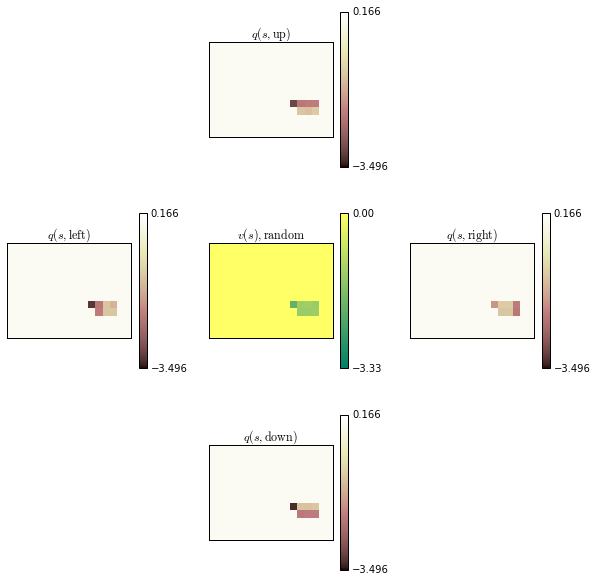

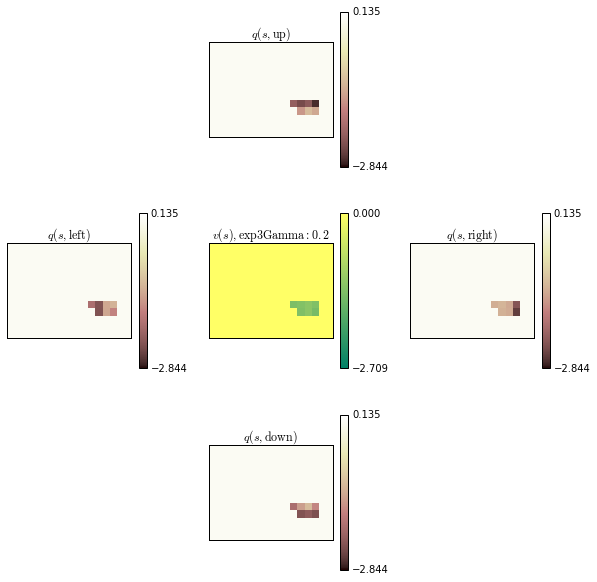

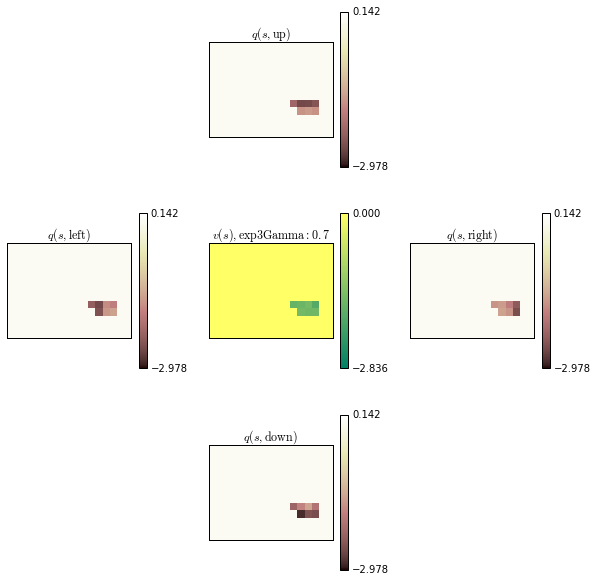

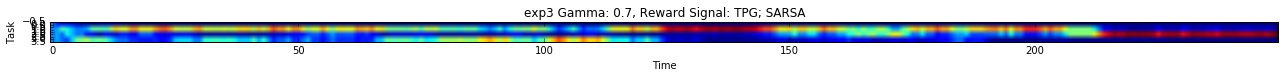

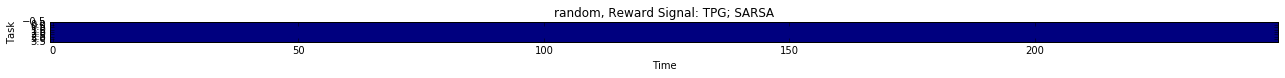

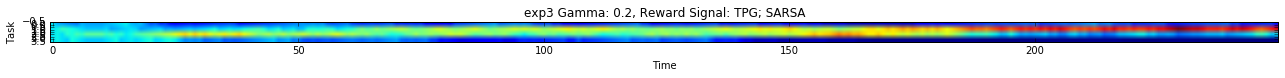

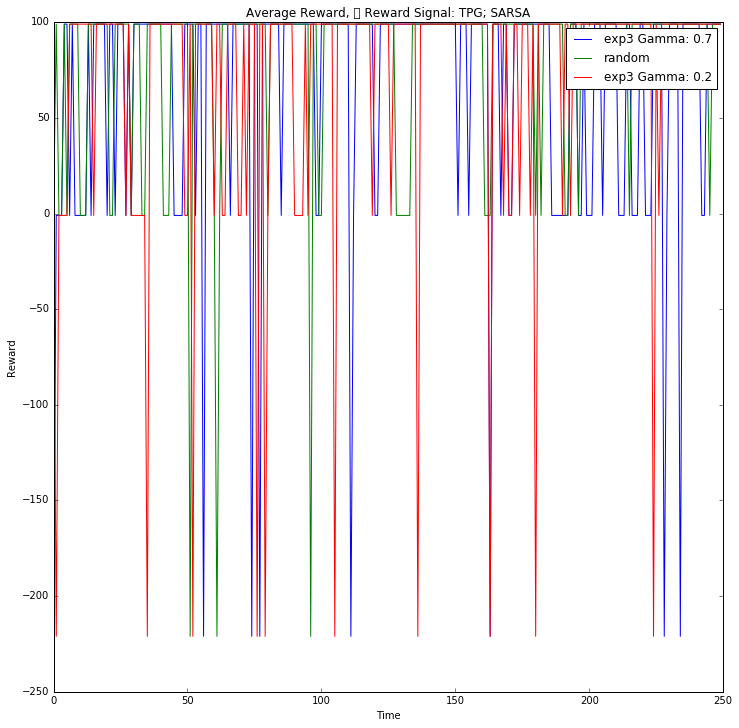

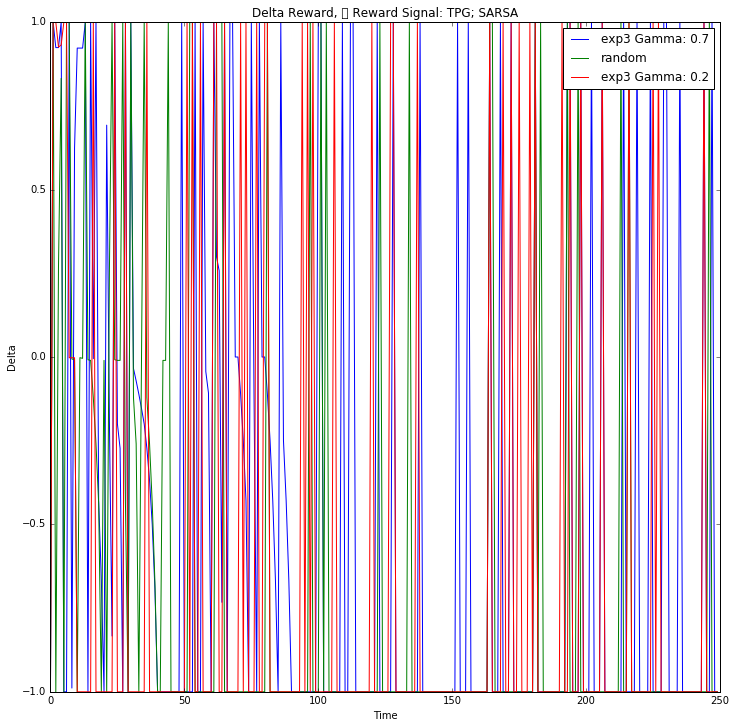

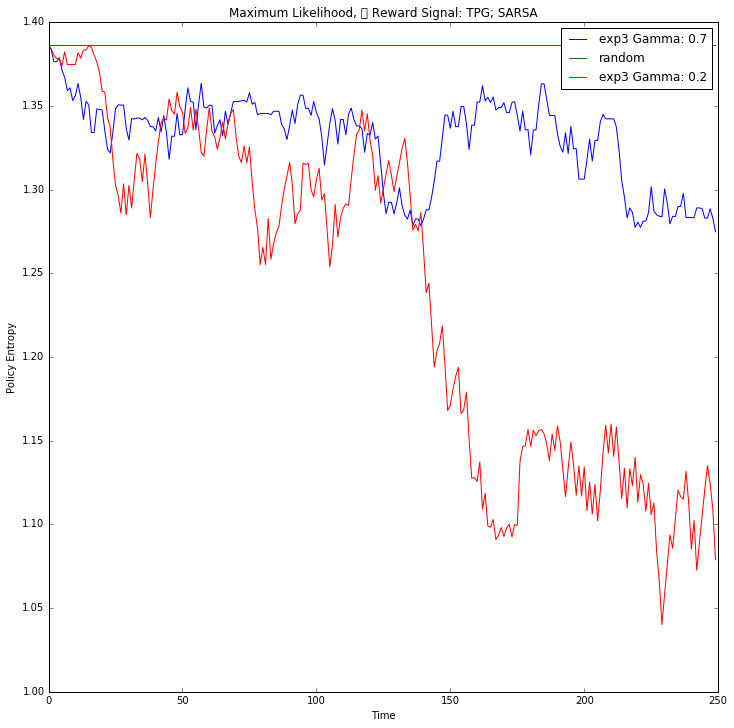

In [1234]:
# goal_loc has format (row, col)
tasks = []
tasks.append(Hallway(goal_loc = (8, 2), value=-3, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 2), value=1, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 13), value=1, discount=0.98))
tasks.append(Hallway(goal_loc = (8, 13), value=100, discount=0.98))

for task in tasks:
  task.plot_grid()
  
# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
     EXP3(number_of_arms_tasks, 0.2),
     EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
#       REINFORCE(number_of_arms_tasks),
#       REINFORCE(number_of_arms_tasks, baseline=True),
]


train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks, 
                  tasks,
                  reward_signal,
                  reps,
                  agent_type='SARSA')

  
# # A. Training on the Longest Hallway Only
# # B. Manual Curriculum, shortest to longest hallway
# # C. Uniform Sampling
# # D. Graves Bandit
# # E. RL for Curriculum Selection

Running: random
-1.17351499899 0.0
Running: exp3 Gamma: 0.2
-21.0169903597 0.0
Running: exp3 Gamma: 0.7
-1.0018382511 0.0


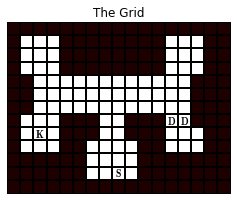

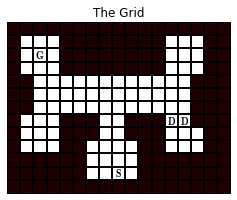

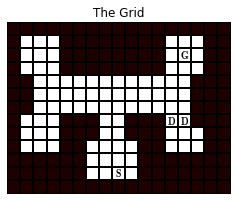

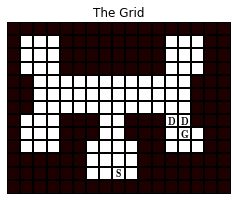

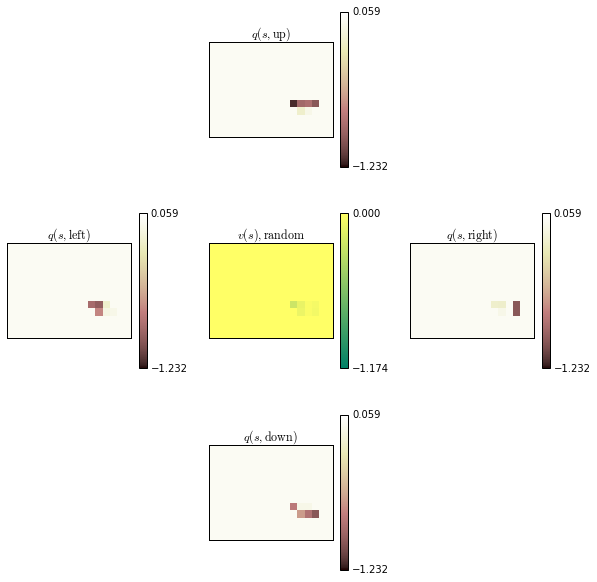

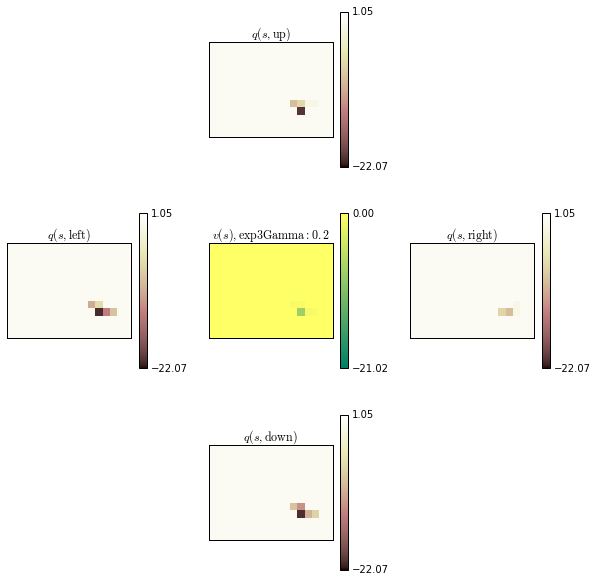

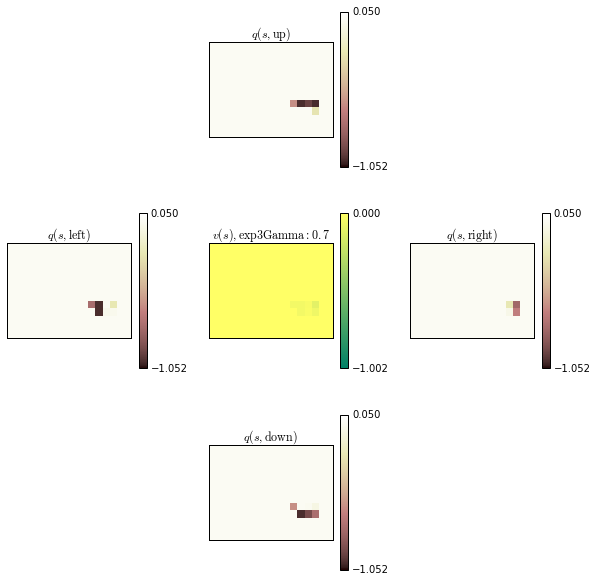

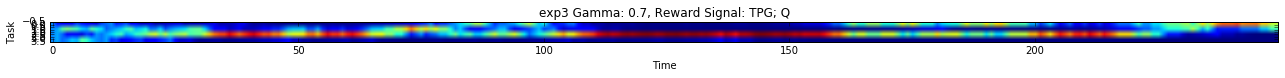

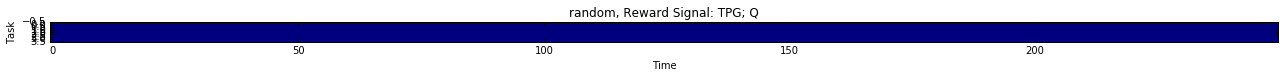

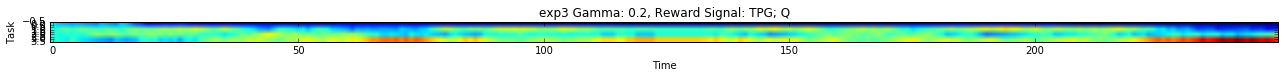

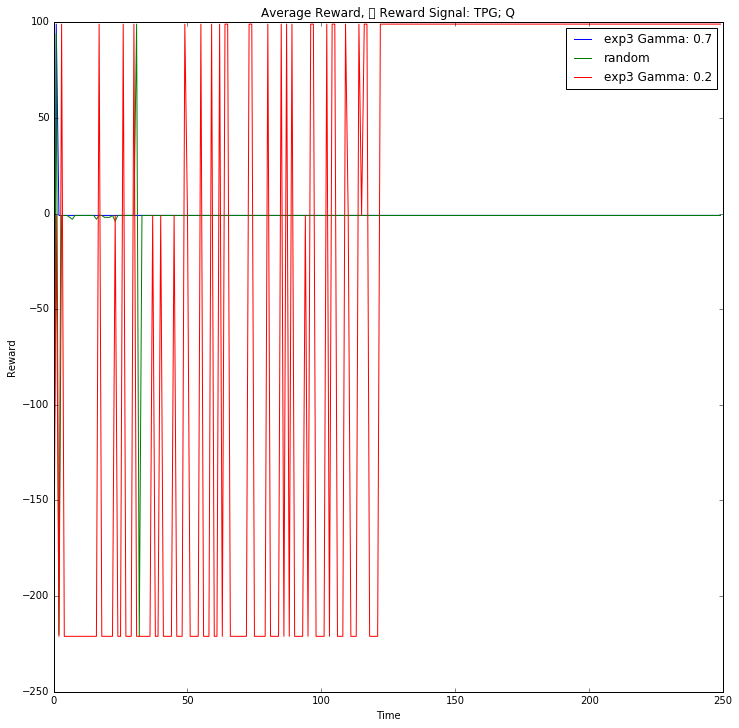

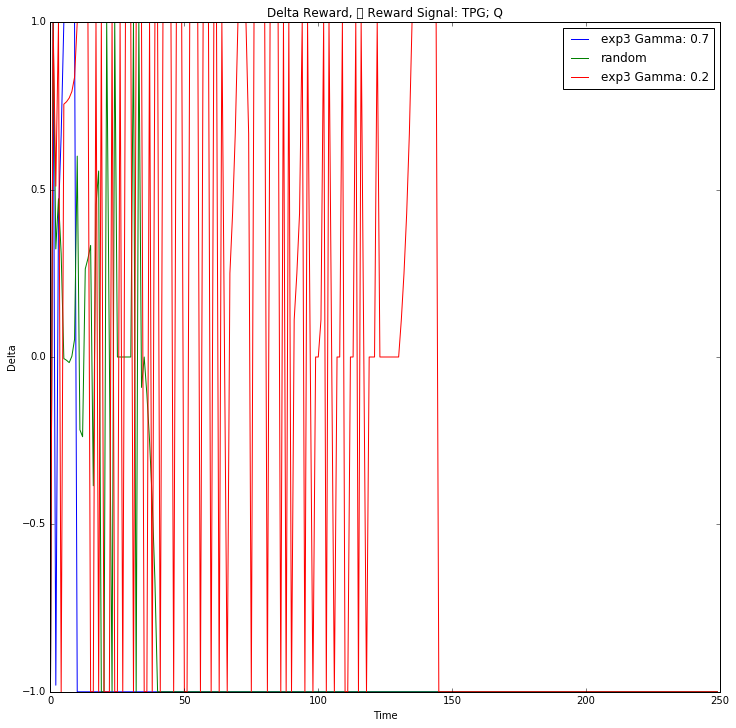

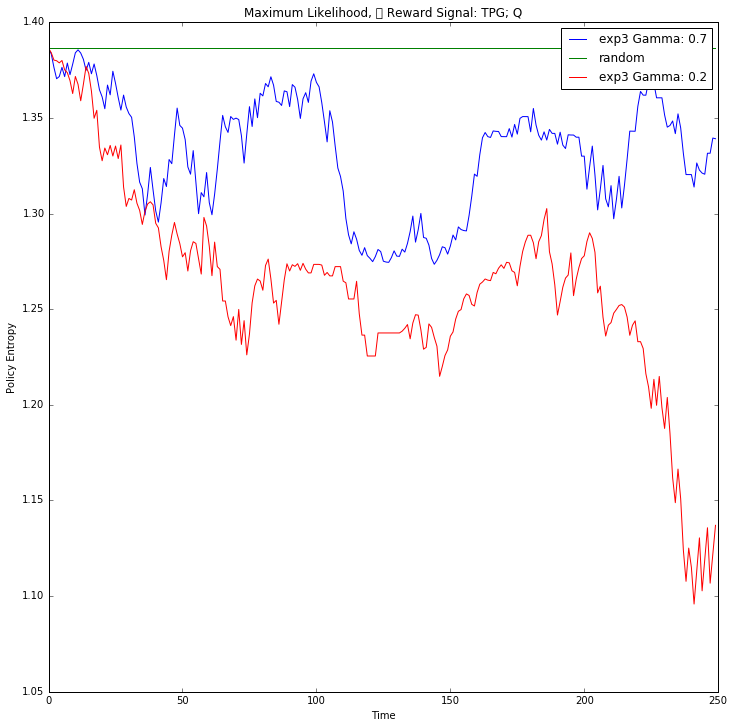

In [1235]:
# goal_loc has format (row, col)
tasks = []
tasks.append(Hallway(goal_loc = (8, 2), value=-3, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 2), value=1, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 13), value=1, discount=0.98))
tasks.append(Hallway(goal_loc = (8, 13), value=100, discount=0.98))

for task in tasks:
  task.plot_grid()
  
# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
      EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
#       REINFORCE(number_of_arms_tasks),
#       REINFORCE(number_of_arms_tasks, baseline=True),
]


train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks, 
                  tasks,
                  reward_signal,
                  reps,
                  agent_type='Q')

  
# # A. Training on the Longest Hallway Only
# # B. Manual Curriculum, shortest to longest hallway
# # C. Uniform Sampling
# # D. Graves Bandit
# # E. RL for Curriculum Selection

### Neural Agents

Running: random
-3.13853942485 0.0
Running: exp3 Gamma: 0.2
-3.58762813067 0.0
Running: exp3 Gamma: 0.7
-3.90653337151 0.0


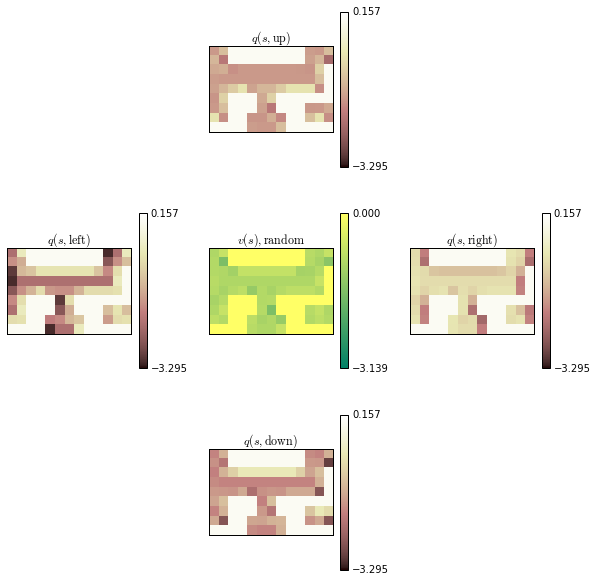

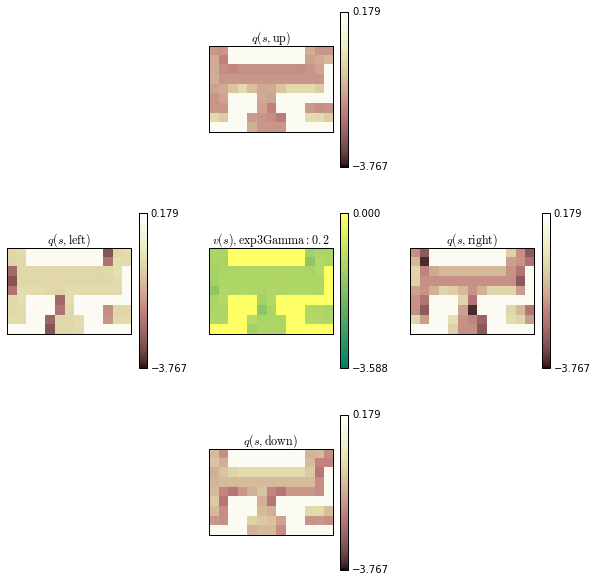

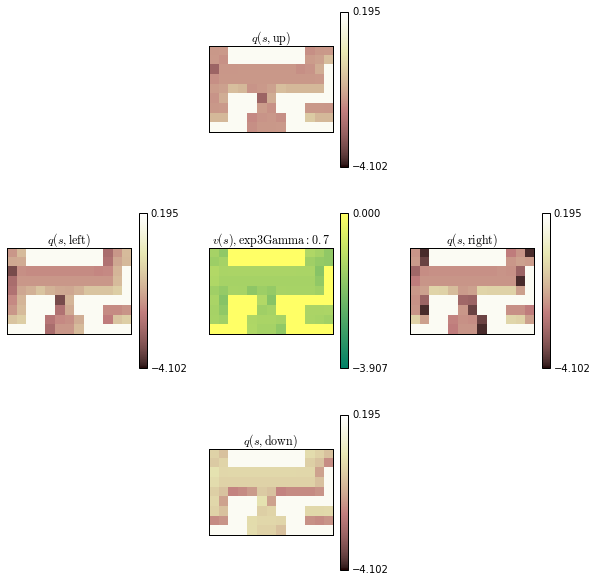

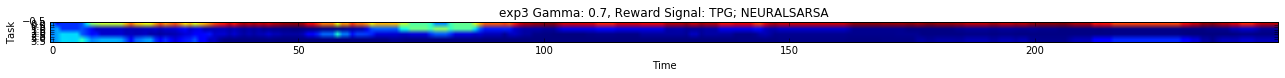

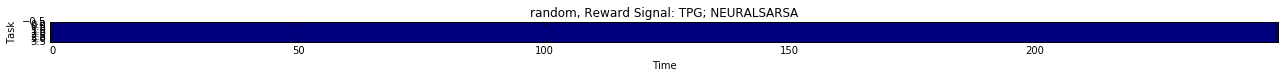

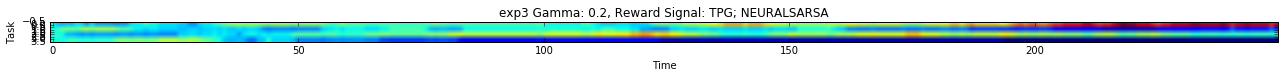

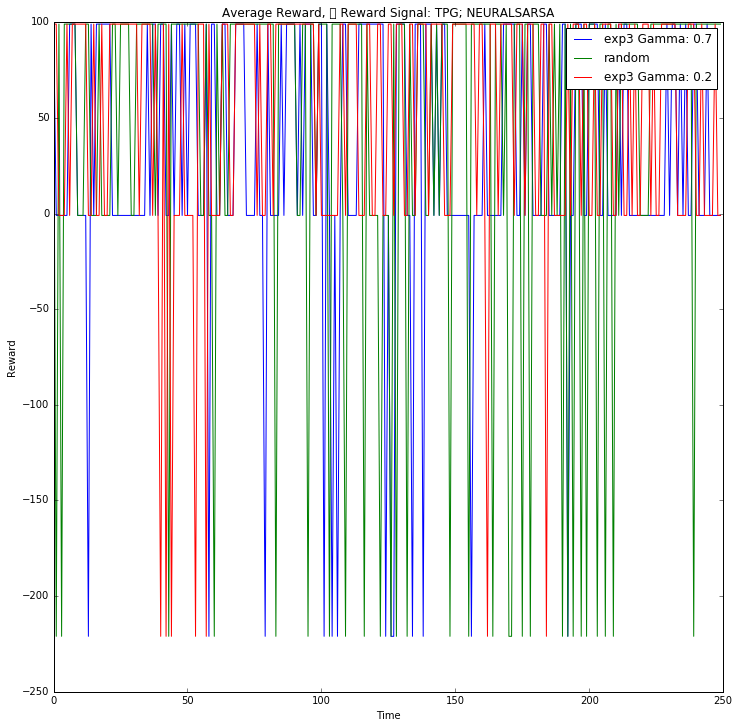

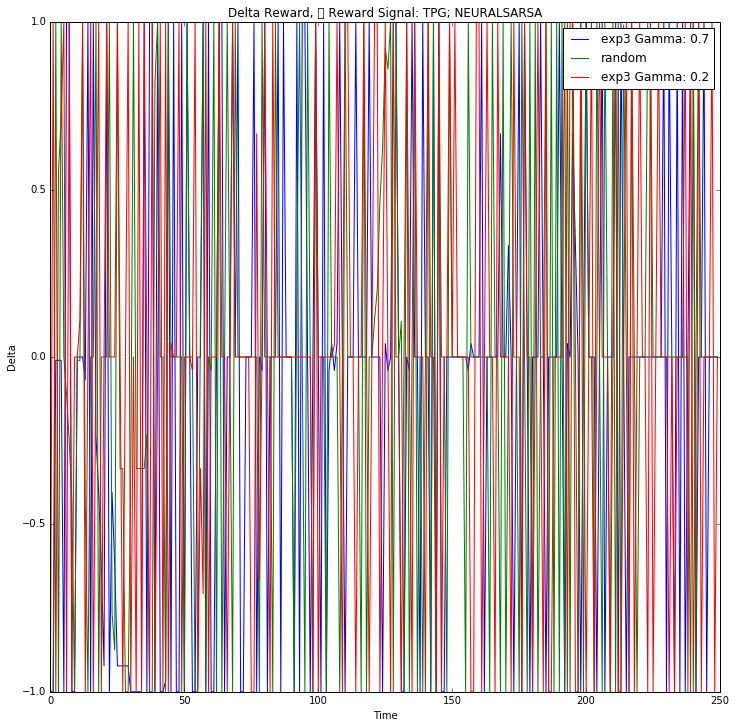

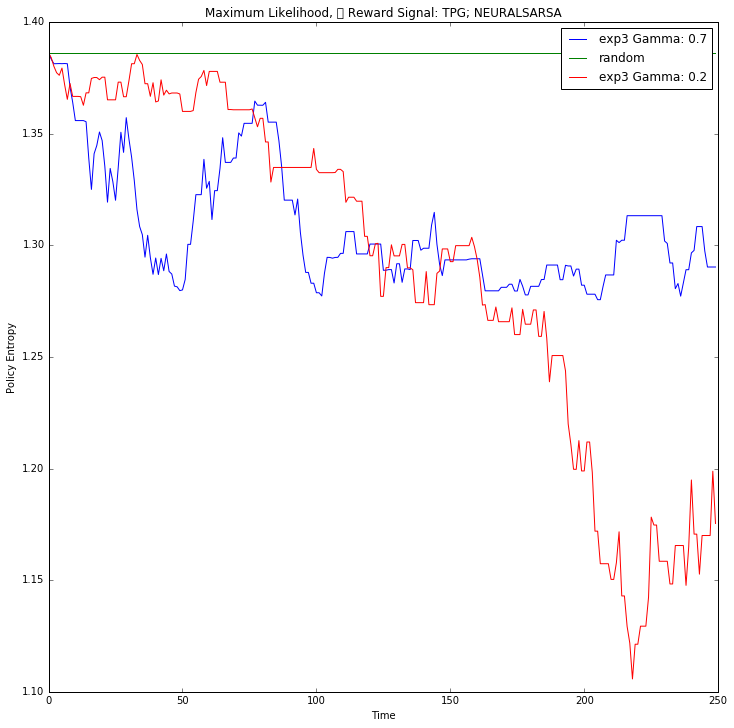

In [1236]:
vision_size = 1
tabular_grid = False
agent_type = 'NEURALSARSA'
hidden_units = 100
step_size = 0.01

# goal_loc has format (row, col)
tasks = []
tasks.append(Hallway(goal_loc = (8, 2), value=-3, tabular=tabular_grid, vision_size=vision_size, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 2), value=1, tabular=tabular_grid, vision_size=vision_size, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 13), value=1, tabular=tabular_grid, vision_size=vision_size,discount=0.98))
tasks.append(Hallway(goal_loc = (8, 13), value=100, tabular=tabular_grid, vision_size=vision_size, discount=0.98))

# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
       EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
#      REINFORCE(number_of_arms_tasks),
#      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks,
                  tasks,
                  reward_signal,
                  reps,
                  vision_size,
                  tabular_grid,
                  agent_type,
                  hidden_units,
                  step_size)

#h, w = grid._layout.shape
#obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
#qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
#plot_action_values(qs)

Running: random
-0.782743393694 0.863730858196
Running: exp3 Gamma: 0.2
-1.19122199122 0.767926757471
Running: exp3 Gamma: 0.7
-1.42303246675 0.66762177734


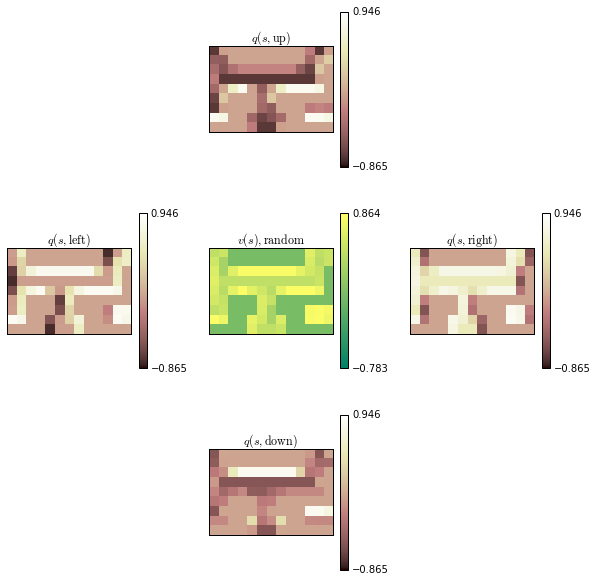

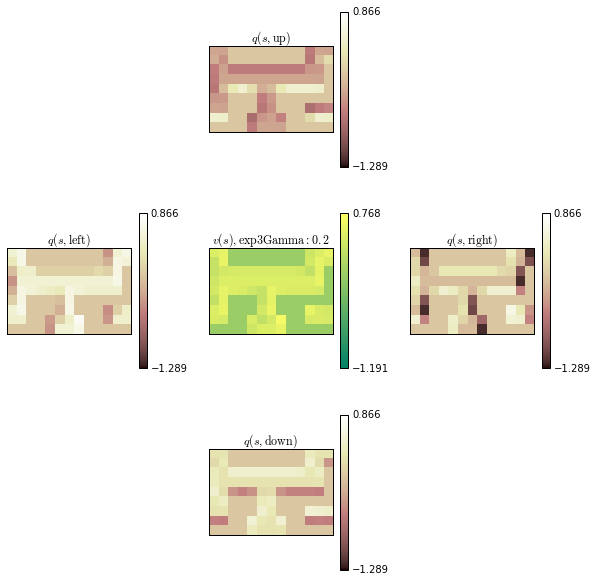

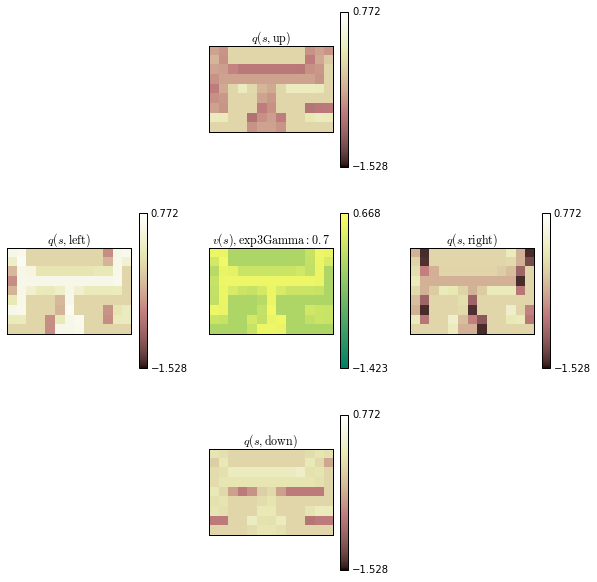

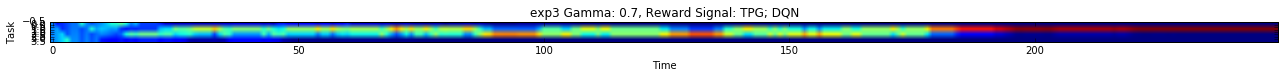

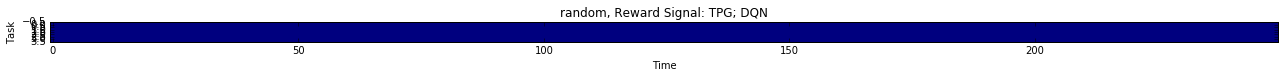

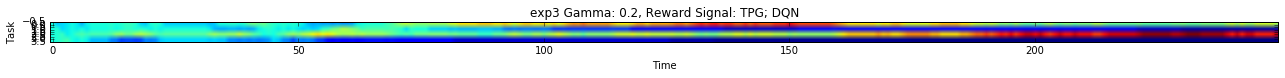

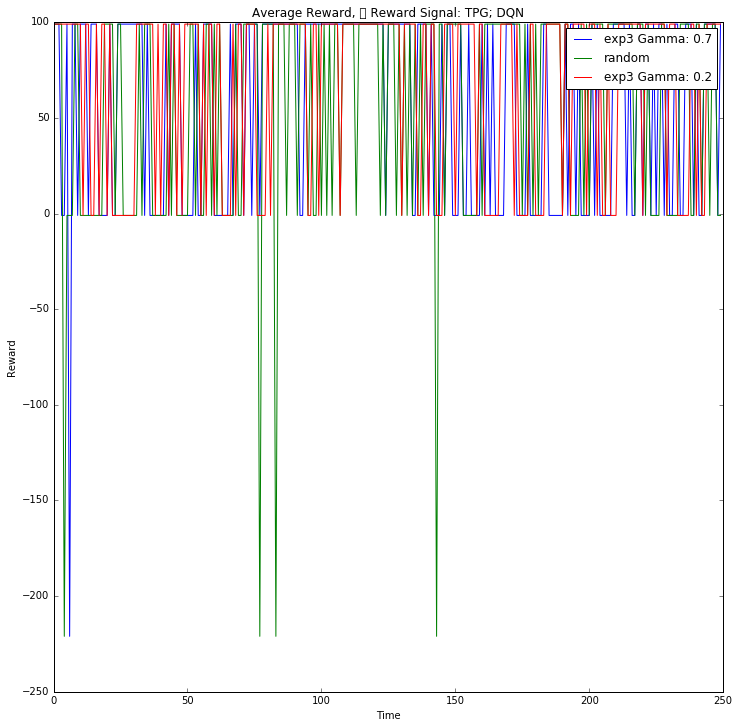

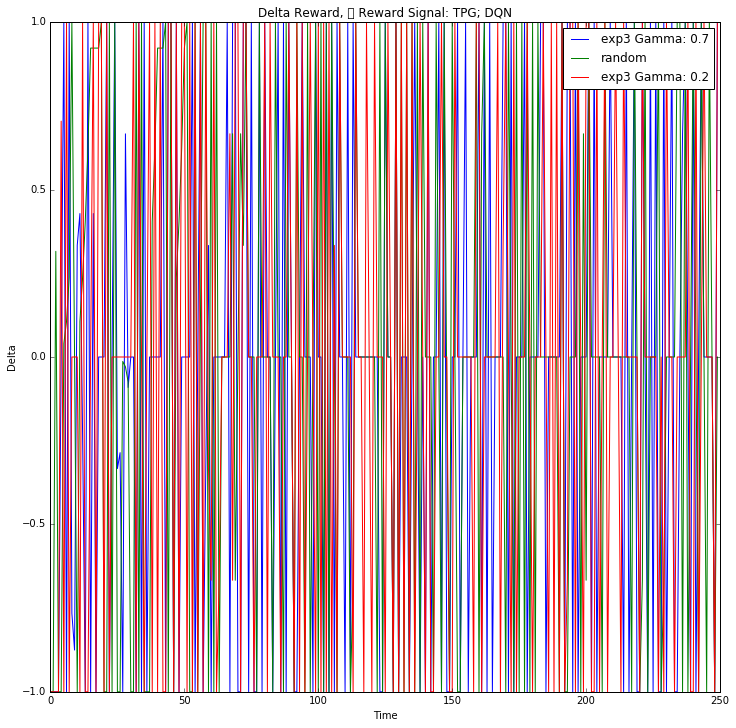

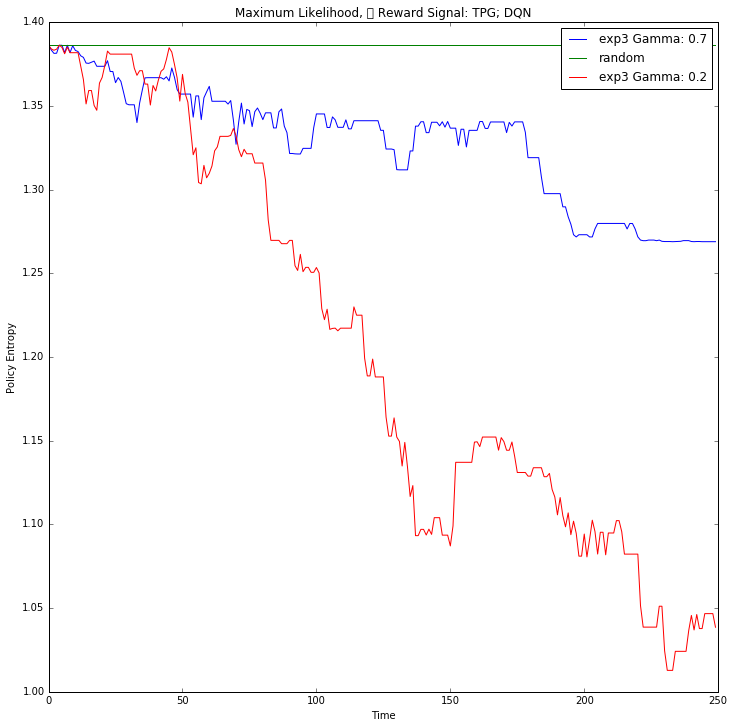

In [1237]:
vision_size = 1
tabular_grid = False
agent_type = 'DQN'
hidden_units = 100
step_size = 0.01

tasks = []
tasks.append(Hallway(goal_loc = (8, 2), value=-3, tabular=tabular_grid, vision_size=vision_size, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 2), value=1, tabular=tabular_grid, vision_size=vision_size, discount=0.98))
tasks.append(Hallway(goal_loc = (2, 13), value=1, tabular=tabular_grid, vision_size=vision_size,discount=0.98))
tasks.append(Hallway(goal_loc = (8, 13), value=100, tabular=tabular_grid, vision_size=vision_size, discount=0.98))

# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
     EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
#      REINFORCE(number_of_arms_tasks),
#      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks,
                  tasks,
                  reward_signal,
                  reps,
                  vision_size,
                  tabular_grid,
                  agent_type,
                  hidden_units,
                  step_size)

#h, w = grid._layout.shape
#obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
#qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
#plot_action_values(qs)

# Inventory as a Contextual Bandit


# 'Learning How to Learn' Experiments in Curriculum Learning (in Hallways)


# 'Dynamic and Hierarchical' Experiments in Curriculum Learning (in Hallways)


# Generative Model for Goals or Tasks in Curriculum Learning